### Testing Notebook

This notebook contains the test plan for the autoliftout automation refactor

In [1]:
%load_ext autoreload 
%autoreload 2
from liftout import utils, patterning, actions
from fibsem import acquire, calibration, movement, validation, milling, alignment
from fibsem import utils as fibsem_utils
from liftout.detection import detection
from liftout.detection import utils as det_utils
from liftout.sample import Sample, Lamella, AutoLiftoutStage, AutoLiftoutState, MicroscopeState
from fibsem.structures import Point, BeamType, ImageSettings
from liftout.detection.detection import DetectionType, DetectionFeature
from liftout.structures import ReferenceHFW

from liftout import autoliftout
from liftout.utils import take_reference_images_and_plot
from autoscript_sdb_microscope_client.structures import AdornedImage, MoveSettings, StagePosition, ManipulatorPosition, Rectangle
from autoscript_sdb_microscope_client import SdbMicroscopeClient

import numpy as np
import os
import matplotlib.pyplot as plt
import glob
from pprint import pprint

c:\Users\Admin\.conda\envs\liftout\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Notes

Needle needs a warm up to insert to the correct position

needle position is off by 5um,

eucentric to park




In [ ]:
# common
microscope, settings = utils.f()

image_settings = settings.image
pprint(image_settings)
pprint(lamella)
pprint(sample)

In [ ]:

def check_rotation_is_close(r1: float, r2: float, atol: float = 90) -> bool:
    """_summary_

    Args:
        r1 (float): rotation 1 (degrees)
        r2 (float): rotation 2 (degrees)
        atol (float, optional): tolerance between rotations (degrees). Defaults to 90.

    Returns:
        bool: rotations are close
    """
    r1_rad = np.deg2rad(r1) % (2 * np.pi)
    r2_rad = np.deg2rad(r2) % (2 * np.pi)

    # works for multiples of 2pi
    # doesnt work for crossing over 0

    return np.isclose(r1_rad, r2_rad, atol=np.deg2rad(atol))

assert check_rotation_is_close(50, 50, 90) ==  True, "Rotation is close"
assert check_rotation_is_close(50, 230, 90) ==  False, "Rotation is not close"
assert check_rotation_is_close(50, -360+50, 90) ==  True, "Rotation is close"
assert check_rotation_is_close(2, 358, 90) ==  True, "Rotation is close"

# TODO: add this...


In [ ]:
a1 = np.deg2rad(50)
a2 = np.deg2rad(-50)

da = movement.angle_difference(a1, a2)
close = movement.rotation_angle_is_larger(a1, a2)

print(f"close: {close}, da: {np.rad2deg(da):.4f}, a1: {a1:.4f}, a2: {a2:.4f}")



##### EUCENTRIC CORRECTION

In [ ]:
# EUCENTRIC HEIGHT ADJUSTMENT FROM IMAGE COORDINATES
dy = -5.5e-6
movement.move_stage_eucentric_correction(microscope, dy)

take_reference_images_and_plot(microscope, image_settings)

In [ ]:
# coarse eucentric alignment
EUCENTRIC_HEIGHT = 3.91e-3
alignment.coarse_eucentric_alignment(microscope, hfw=30e-6, eucentric_height=EUCENTRIC_HEIGHT)

In [ ]:
# fine alignment
alignment.correct_stage_eucentric_alignment(microscope, image_settings)

#### STATE MANAGEMENT

In [ ]:
lamella.lamella_state = calibration.get_current_microscope_state(microscope)

In [ ]:
pprint(lamella)

In [ ]:

sample = autoliftout.update_sample_lamella_data(sample, lamella)


In [ ]:
# calibration.set_microscope_state(microscope, landing_state)
take_reference_images_and_plot(microscope, image_settings)

##### 1. Mill Trench
1. Mill a trench so we have a feature to work with

In [ ]:
movement.move_flat_to_beam(microscope, settings, BeamType.ION)

In [ ]:
# actions.move_to_sample_grid(microscope, settings)

microscope.patterning.clear_patterns()
milling_settings = patterning.get_milling_protocol_stage_settings(settings, patterning.MillingPattern.Trench)
milling_stage_patterns = []
for stage_settings in milling_settings:
    patterns = patterning.mill_trench_patterns(microscope, stage_settings)
    milling_stage_patterns.append(patterns)

In [ ]:
milling.run_milling(microscope, milling_current=28.0e-9)
milling.finish_milling(microscope)

In [ ]:

import datetime
total_time_seconds = milling.estimate_milling_time_in_seconds(milling_stage_patterns)
time_str = str(datetime.timedelta(seconds=total_time_seconds)).split(".")[0]
print(time_str)

##### 6. CrossCorrelation

Flat Cross Correlation
1. Move to trench (flat IB)
2. Take reference images
3. Move flat to EB
4. Cross correlate (rotated ref_ib)
5. Measure accuracy, how far away is the lamella centre
6. Try masking reference image to improve accuracy


NOTE: need to retest the align_with_reference_image functions because there was inconsistency between how the references were passed...
might be effectign some thing


To Test:
- Reference / New image order is correct
- Movement directions are correct
- X/Y pixelsize is the same (I think this is a bug)

In [ ]:
# manually move to trench

# TODO: do this for low res and high res??
# settings.image.hfw = ReferenceHFW.Low.value
settings.image.hfw = ReferenceHFW.High.value
# settings.image.hfw = ReferenceHFW.Super.value
settings.image.save = True
settings.image.label = "ref_" + fibsem_utils.current_timestamp()

# move flat to ib
# movement.move_flat_to_beam(microscope, settings, beam_type=BeamType.ION)

ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

# move flat to eb
movement.move_flat_to_beam(microscope, settings, beam_type=BeamType.ELECTRON)

new_eb, new_ib = take_reference_images_and_plot(microscope, image_settings)
settings.image.label = "new_" + fibsem_utils.current_timestamp()


# lp_px = 128 #int(max(new_eb.data.shape) * 0.66)
# hp_px = 6 #int(max(new_eb.data.shape) / 64)
# sigma = 6

# # cross correlate and plot
# utils.crosscorrelate_and_plot(ref_ib, new_eb, rotate=True, lp=lp_px, hp=hp_px, sigma=sigma)

# align and move...
ref_mask = calibration.create_lamella_mask(ref_ib, settings, factor=4, circ=False)

calibration.align_using_reference_images(microscope, settings, calibration.rotate_image(ref_ib), new_eb, ref_mask=ref_mask)

after_eb, after_ib = take_reference_images_and_plot(microscope, image_settings)
settings.image.label = "after" + fibsem_utils.current_timestamp()

utils.plot_two_images(calibration.rotate_image(ref_ib), after_eb)


#### Correct Stage Drift ()

In [ ]:
movement.move_flat_to_beam(microscope, settings, BeamType.ION)

In [ ]:
# TODO: do this for low res and high res??
# settings.image.hfw = ReferenceHFW.Low.value
settings.image.hfw = ReferenceHFW.High.value
# settings.image.hfw = ReferenceHFW.Super.value
settings.image.save = True
settings.image.label = "ref_" + fibsem_utils.current_timestamp()


# move flat to ib
# movement.move_flat_to_beam(microscope, settings, beam_type=BeamType.ION)

ref_low_eb, ref_low_ib = take_reference_images_and_plot(microscope, image_settings)
settings.image.hfw = ReferenceHFW.Super.value
settings.image.label = "ref_high" + fibsem_utils.current_timestamp()
ref_high_eb, ref_high_ib = take_reference_images_and_plot(microscope, image_settings)

from fibsem.structures import ReferenceImages
reference_images = ReferenceImages(
    ref_low_eb, ref_high_eb, ref_low_ib, ref_high_ib
)


# move flat to eb
movement.move_flat_to_beam(microscope, settings, beam_type=BeamType.ELECTRON)
calibration.correct_stage_drift(
    microscope, settings, image_settings, reference_images=reference_images,
    alignment=(BeamType.ION, BeamType.ELECTRON), rotate=True
)


after_eb, after_ib = take_reference_images_and_plot(microscope, image_settings)
settings.image.label = "after_high" + fibsem_utils.current_timestamp()

utils.plot_two_images(calibration.rotate_image(ref_high_ib), after_eb)

Tilt Cross Correlation
1. Move to trench (flat to EB)
2. Take reference images
3. Tilt +6 degrees
4. Take reference images
5. Cross correlate (eb - eb)
6. Measure accuracy
7. Try masking reference, cosine stretch

In [ ]:
movement.move_flat_to_beam(microscope, settings, beam_type=BeamType.ELECTRON)
settings.image.hfw = 80e-6
take_reference_images_and_plot(microscope, image_settings)

In [ ]:
# manually move to trench

# TODO: do this for low res and high res??
# TODO: do this for eb/ib pairs

# settings.image.hfw = ReferenceHFW.Low.value
# settings.image.hfw = ReferenceHFW.High.value
settings.image.hfw = ReferenceHFW.Super.value
settings.image.save = True
settings.image.label = "ref_tilt" + fibsem_utils.current_timestamp()

# move flat to ib
movement.move_flat_to_beam(microscope, settings, beam_type=BeamType.ELECTRON)

ref_eb, ref_ib = take_reference_images_and_plot(microscope, image_settings)

for i in range(1):


    # titlt to jcut angle
    TILT_DEGREES = 6
    microscope.specimen.stage.relative_move(StagePosition(t=np.deg2rad(TILT_DEGREES)))
    settings.image.label = f"new_tilt_{i}_" + fibsem_utils.current_timestamp()
    new_eb, new_ib = take_reference_images_and_plot(microscope, image_settings)

    lp_px = int(max(new_eb.data.shape) * 0.66)
    hp_px = int(max(new_eb.data.shape) / 64)
    sigma = 6

    mask = calibration.create_lamella_mask(ref_ib, settings, factor=2.5, circ=False)

    # cross correlate and plot
    utils.crosscorrelate_and_plot(ref_ib, new_ib, rotate=False, lp=lp_px, hp=hp_px, sigma=sigma, ref_mask=mask)
    utils.plot_two_images(ref_ib, calibration.apply_image_mask(ref_ib, mask))
    
    # align and move...
    calibration.align_using_reference_images(microscope, settings, calibration.cosine_stretch(ref_ib, i*TILT_DEGREES), new_ib, ref_mask = mask)

    after_eb, after_ib = take_reference_images_and_plot(microscope, image_settings)
    settings.image.label = f"after_{i}_" + fibsem_utils.current_timestamp()

    utils.plot_two_images(ref_ib, after_ib)

In [ ]:
mask = calibration.create_lamella_mask(ref_ib, settings, factor=2.5, circ=False)

utils.plot_two_images(ref_ib, calibration.apply_image_mask(ref_ib, mask))

##### 7. Eucentric Correction

Cross Correlation eucentric correction
1. Move to trench
2. make eucentricity bad
3. test eucentric correction function (CC)


N.B. Need to test this in other conditions for robustness


12. Thin Lamella

Align Thin Lamella
1. Move to Landing Position
2. Take reference images
3. Rotate and tilt to thinning angle
4. Take reference images
5. Align to reference images
6. Run Milling

In [ ]:
# manually move to landing position

# # take reference images
# eb_image, ib_image = acquire.take_reference_images(microscope, image_settings) 

# # rotate and tilt to thinning angle
# actions.move_to_thinning_angle(microscope, settings)

# calibration.correct_stage_drift(microscope, settings, image_settings, alignment=(BeamType.ELECTRON, BeamType.ION), rotate=True)



13. Polish Lamella

Align Polish Lamella
1. Move to thinning position
2. Take reference images
5. Align to reference images
6. Run Milling

In [ ]:
#### liftout lamella

from liftout.sample import load_experiment
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\test-run-room-temp_2022-08-15.12-07-57PM"
sample = load_experiment(path)

lamella_no = list(sample.positions.keys())[0]
lamella: Lamella = sample.positions[lamella_no]

movement.safe_absolute_stage_movement(
    microscope=microscope,
    stage_position=lamella.landing_state.absolute_position,
)

movement.safe_absolute_stage_movement(microscope, lamella.lamella_state.absolute_position)
# actions.move_to_liftout_angle(microscope, settings)

take_reference_images_and_plot(microscope, image_settings)


In [ ]:
movement.move_flat_to_beam(microscope, settings, BeamType.ELECTRON)

In [ ]:
if microscope.specimen.manipulator.state == "Inserted":
    print("retracting")
    movement.retract_needle(microscope)

settings.image.hfw = ReferenceHFW.High.value
# # take_reference_images_and_plot(microscope, image_settings)
# actions.move_needle_to_liftout_position(microscope)
# actions.move_needle_to_landing_position(microscope)
# autoliftout.land_needle_on_milled_lamella(microscope, settings, image_settings, lamella)
take_reference_images_and_plot(microscope, image_settings)

#### Brightness GIF

In [ ]:

path = r"C:\Users\Admin\Github\autoliftout\liftout\tools\auto\data\brightness"
search = "bright_*.tif"
gif_fname = "brightness"
from PIL import Image
from pathlib  import Path



fibsem_utils.create_gif(path, search, gif_fname, loop=1)

In [ ]:
path = r"C:\Users\Admin\Github\autoliftout\liftout\log\test-run-room-temp_2022-08-15.12-07-57PM\01-finer-parrot"
search = "ref_*_low_res_ib.tif"
gif_fname = "low_res_ib"

fibsem_utils.create_gif(path, search, gif_fname)

In [2]:
# hfws = [ReferenceHFW.Medium.value, ReferenceHFW.Super.value]
# reference_images = acquire.take_set_of_reference_images(
#     microscope, settings.image, hfws=hfws, label="ref_trench"
# )

from fibsem.structures import ReferenceImages

microscope, settings = utils.quick_setup()

low_ref_ib = AdornedImage.load(r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-test-refactor_2022-08-24.02-50-43PM\01-fancy-eft/ref_trench_low_res_ib.tif")
high_ref_ib = AdornedImage.load(r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-test-refactor_2022-08-24.02-50-43PM\01-fancy-eft/ref_trench_high_res_ib.tif")


reference_images = ReferenceImages(
    low_res_eb=None,
    high_res_eb=None,
    low_res_ib=low_ref_ib,
    high_res_ib=high_ref_ib
)

# move flat to electron beam
# movement.move_flat_to_beam(microscope, settings, beam_type=BeamType.ELECTRON)

# correct drift using reference images..
# alignment.correct_stage_drift(
#     microscope,
#     settings,
#     reference_images,
#     alignment=(BeamType.ION, BeamType.ELECTRON),
#     rotate=True,
# )



2022-08-24 16:11:28,285 — root — INFO — connect_to_microscope:28 — Microscope client connecting to [10.0.0.1]
2022-08-24 16:11:28,318 — root — INFO — connect_to_microscope:31 — Microscope client connected to [10.0.0.1]


Client connecting to [10.0.0.1:7520]...
Client connected to [10.0.0.1:7520]


AttributeError: 'NoneType' object has no attribute 'dwell_time'

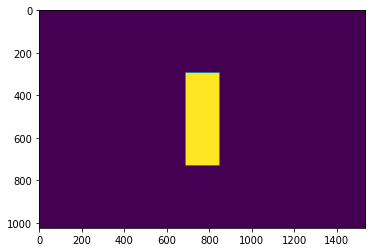

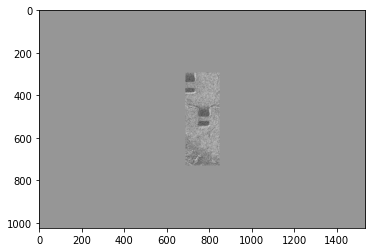

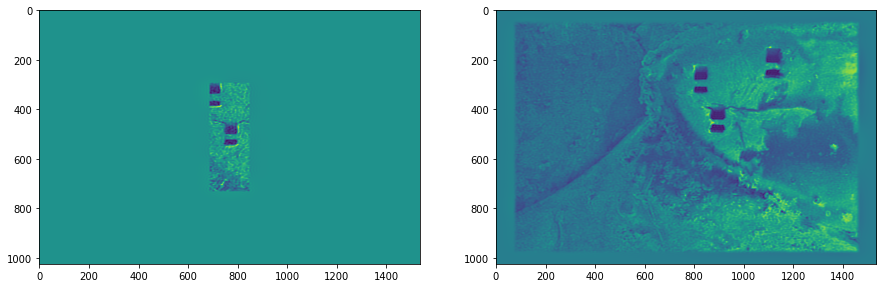

2022-08-24 16:20:34,320 — root — INFO — shift_from_crosscorrelation:234 — pixelsize: x: 2.60417e-07, y: 2.60417e-07
2022-08-24 16:20:34,321 — root — INFO — shift_from_crosscorrelation:236 — cross-correlation:
2022-08-24 16:20:34,322 — root — INFO — shift_from_crosscorrelation:237 — maxX: 569, 646, centre: [512. 768.]
2022-08-24 16:20:34,323 — root — INFO — shift_from_crosscorrelation:238 — x: 122px, y: -57px
2022-08-24 16:20:34,324 — root — INFO — shift_from_crosscorrelation:239 — x: 3.18e-05m, y: -1.48e-05 meters


shift_m: 3.1770874e-05, -1.4843769000000002e-05
shift_px: 121, -57


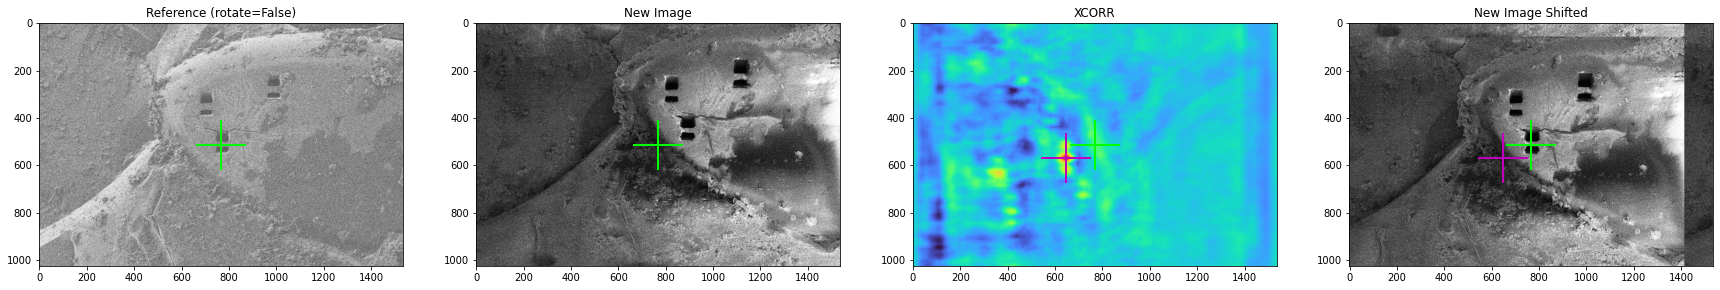

(3.1770874e-05,
 -1.4843769000000002e-05,
 array([[19450.85627635, 18525.74570785, 17376.68316307, ...,
         20816.21396841, 20591.63724716, 20139.64695916],
        [19497.92259935, 18573.34165277, 17420.21965028, ...,
         20831.37346209, 20621.8587481 , 20180.86053326],
        [19524.64873655, 18600.71595168, 17443.40639282, ...,
         20825.61477012, 20631.20433458, 20201.46454417],
        ...,
        [19323.57272218, 18407.29489143, 17272.215403  , ...,
         20712.08875079, 20471.12923459, 20011.31140102],
        [19351.34360335, 18429.49269143, 17288.8740961 , ...,
         20749.10589328, 20506.80834451, 20043.78269966],
        [19397.39375857, 18472.83507415, 17327.77249455, ...,
         20786.37403847, 20549.97754701, 20089.90605947]]))

In [10]:
from fibsem.imaging.utils import rotate_image
from fibsem.imaging import masks
new_image = AdornedImage.load(r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-test-refactor_2022-08-24.02-50-43PM\01-fancy-eft/2022-08-24.03-53-23PM_eb.tif")
ref_image = rotate_image(low_ref_ib)
ref_mask = masks.create_lamella_mask(ref_image, settings.protocol["lamella"], scale=4, use_trench_height=True)

plt.imshow(ref_mask)
plt.show()

# ret = alignment.align_using_reference_images(
#     microscope, settings, ref_image, new_image, ref_mask=ref_mask
# )

utils.crosscorrelate_and_plot(ref_image, new_image, rotate=False, ref_mask=ref_mask)


2022-08-24 18:21:04,498 — root — INFO — get_initial_position:147 — DetectionType.NeedleTip: Point(x=768, y=512)
2022-08-24 18:21:05,455 — root — INFO — get_initial_position:147 — DetectionType.ImageCentre: Point(x=768, y=512)


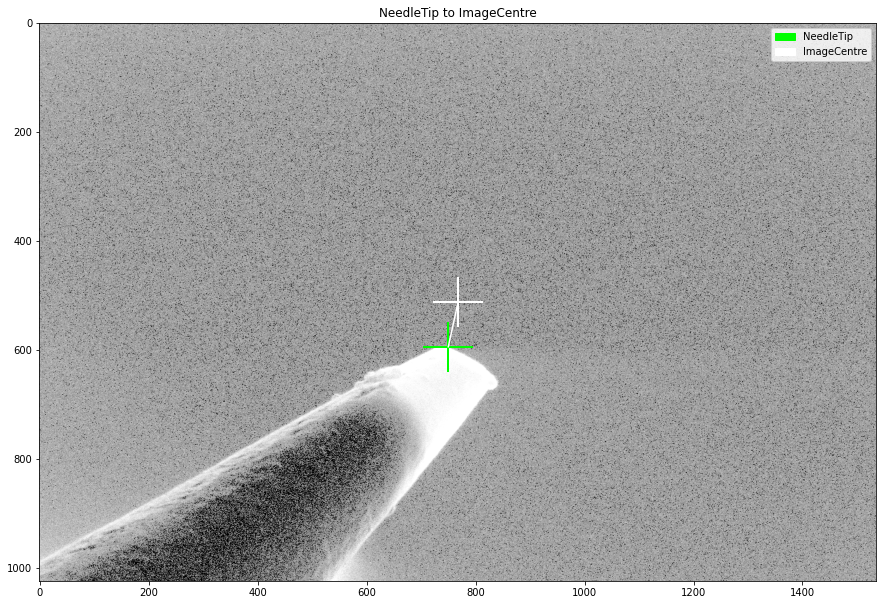

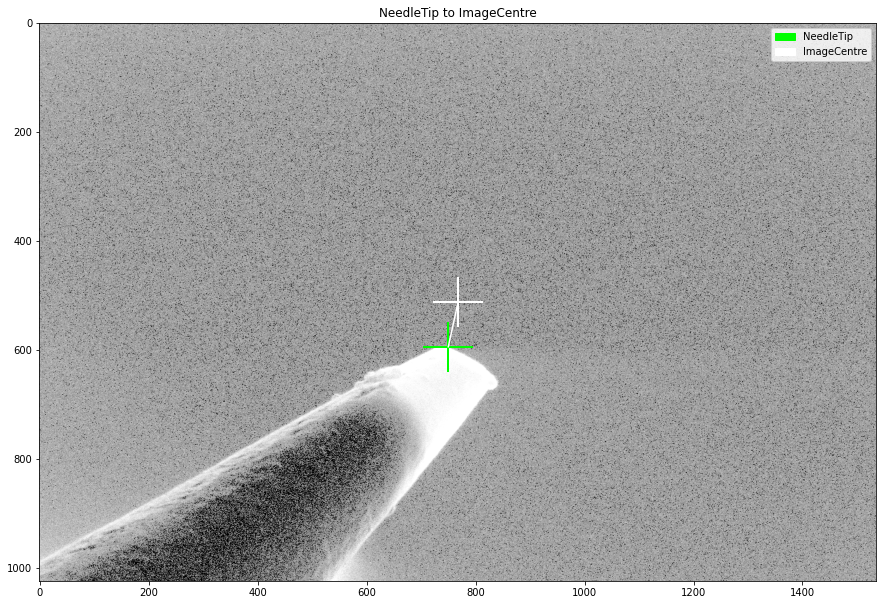

In [15]:
path =  r"C:\Users\Admin\Github\autoliftout\liftout\log\dm-embryo-test-refactor_2022-08-24.02-50-43PM\02-proper-amoeba/sharpen_needle_start_position_ib.tif"

image = AdornedImage.load(path)
ref_image = None

features =  [DetectionFeature(DetectionType.NeedleTip, None),
                DetectionFeature(DetectionType.ImageCentre, None)]

det = detection.locate_shift_between_features(image, ref_image, features=features)


det_utils.plot_detection_result(det)